<h1>Анализ формулы один с использованием методов машинного обучения и математической статистики</h1>

<h2> Структура </h2>
<ul>
<li><a href="#overtakes">Фиксирующиеся обгоны</a></li>
<li><a href="#overtakes_all">Обгоны в секторах</a></li>
<li><a href="#tracks">Данные о трассах</a></li>
<li><a href="#predictor">Определение результата гонки по квалификации</a></li>
</ul>

<h2 id="overtakes">Первоначальной нашей целью будет прогноз вероятности совершения обгона на каждом из участков трассы.</h2>

<h3>Этап первый: определение обгонов</h3>

In [1]:
import fastf1 as ff1
import pandas as pd
import numpy as np
import math
import requests
from scipy import stats
import logging

selected_season = 2021
selected_race = 15

ff1.Cache.enable_cache('cache')
session = ff1.get_session(selected_season, selected_race, 'R')
quali = ff1.get_session(selected_season, selected_race, 'Q')
quali.load()
quali = quali.results

core           INFO 	Loading data for Russian Grand Prix - Qualifying [v2.2.4]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['4', '55', '63', '44', '3', '14', '77', '18', '11', '31', '5', '10', '22', '6', '16', '7', '47', '99', '9', '33']


In [2]:
quali

,DriverNumber,BroadcastName,Abbreviation,TeamName,TeamColor,FirstName,LastName,FullName,Position,GridPosition,Q1,Q2,Q3,Time,Status,Points
4,4,L NORRIS,NOR,McLaren,FF9800,Lando,Norris,Lando Norris,1.0,0.0,0 days 00:01:47.238000,0 days 00:01:45.827000,0 days 00:01:41.993000,NaT,,0.0
55,55,C SAINZ,SAI,Ferrari,DC0004,Carlos,Sainz,Carlos Sainz,2.0,0.0,0 days 00:01:47.924000,0 days 00:01:46.521000,0 days 00:01:42.510000,NaT,,0.0
63,63,G RUSSELL,RUS,Williams,005AFF,George,Russell,George Russell,3.0,0.0,0 days 00:01:48.303000,0 days 00:01:46.435000,0 days 00:01:42.983000,NaT,,0.0
44,44,L HAMILTON,HAM,Mercedes,00D2BE,Lewis,Hamilton,Lewis Hamilton,4.0,0.0,0 days 00:01:45.992000,0 days 00:01:45.129000,0 days 00:01:44.050000,NaT,,0.0
3,3,D RICCIARDO,RIC,McLaren,FF9800,Daniel,Ricciardo,Daniel Ricciardo,5.0,0.0,0 days 00:01:48.345000,0 days 00:01:46.361000,0 days 00:01:44.156000,NaT,,0.0
14,14,F ALONSO,ALO,Alpine,0090FF,Fernando,Alonso,Fernando Alonso,6.0,0.0,0 days 00:01:47.877000,0 days 00:01:45.514000,0 days 00:01:44.204000,NaT,,0.0
77,77,V BOTTAS,BOT,Mercedes,00D2BE,Valtteri,Bottas,Valtteri Bottas,7.0,0.0,0 days 00:01:46.396000,0 days 00:01:45.306000,0 days 00:01:44.710000,NaT,,0.0
18,18,L STROLL,STR,Aston Martin,006F62,Lance,Stroll,Lance Stroll,8.0,0.0,0 days 00:01:48.322000,0 days 00:01:46.360000,0 days 00:01:44.956000,NaT,,0.0
11,11,S PEREZ,PER,Red Bull Racing,0600EF,Sergio,Perez,Sergio Perez,9.0,0.0,0 days 00:01:46.455000,0 days 00:01:45.834000,0 days 00:01:45.337000,NaT,,0.0
31,31,E OCON,OCO,Alpine,0090FF,Esteban,Ocon,Esteban Ocon,10.0,0.0,0 days 00:01:48.099000,0 days 00:01:46.070000,0 days 00:01:45.865000,NaT,,0.0


In [3]:
session.load(laps=True, telemetry=True)
laps = session.laps
laps['LapEndTime'] = laps['LapStartTime'] + laps['LapTime']

core           INFO 	Loading data for Russian Grand Prix - Race [v2.2.4]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '55', '3', '77', '14', '4', '7', '11', '63', '18', '5', '10', '31', '16', '99', '22', '9', '6', '47']


Сделаем подготовку данных для просчета обгонов
Отберем для каждого гонщика те записи, где менялся гонщик впереди, аналогичные же записи отберем для других гонщиков

<h3> Дальнейшая работа и алгоритм вычисления места обгона </h3>
Алгоритм следующий: для каждого гонщика считается его текущая позиция в каждый момент предполагаемого обгона. Обгон засчитывается, если позиция не была возвращена до конца круга, аналогично в дальнейших версиях алгоритма стоит исключить обгоны из-за заездов на питстоп. Таким образом, алгоритм будет следующим:
<ol style="color: green">
<li>Посчитать сетку на конец круга</li>
<li>Найти смены позиций, если таковые были</li>
<li>Найти где была произведена окончательная смена позиций</li>
<li style="color: red">Выделить места борьбы за место</li>
</ol>

Что считается обгоном: <a href="https://www.motorsport.com/f1/news/overtaking-records-in-f1-most-overtakes-in-a-race-by-a-driver/6718440/">motorsport.com</a>

Чуть более подробно по пунктам:
Первоначальная расстановка берется исходя из квалификации ( данный момент в процессе доработки, т.к. после квалификации перед гонкой могут происходить перестановки )
Далее алгоритм:
1. Берется расстановка на начало круга ( конец предыдущего ) и конец круга
2. Вычисляется массив вида: a = <a style="color: yellow">[1, -1, 0, 2, 0, -2 ... ]</a>, где в каждой ячейке стоит число n - количество потерянных / выигранных позиций относительно начала круга.
3. Находится первый отрицательный элемент в массиве, назовем его <i>x</i>, тогда предыдущие abs(<i>x</i>) элементов - гонщиков, которые пропустили нашего, у предыдущих <i>x</i> элементов вычитается по единице, сам элемент x обнуляется
4. вычисляются <i>x</i> гонщиков впереди, далее: y - рассматриваемый обогнавший гонщик, количество возможных значений <i>y</i>: abs(<i>x</i>)
5. ищется наименьшее время, когда для обгоняемого гонщика ( с <i>x</i> потерянных позиций ), гонщик <i>y</i> оказался впереди, берется X и Y этой позиции и записывается один обгон

Пример:
[22, 11, 10] - номера гонщиков и их расположение на начало круга
[10, 11, 22] - номера гонщиков и их расположение на конец круга

тогда нужный нам массив смены мест:
[2, 0, -2],
первый отрицательный элемент = -2, тогда:
1. ищем обгон 22'ого гощника 10'ым
2. ищем обгон 22'ого гонщика 11'ым

массив смены мест после этого:
[1, -1, 0]
Первый отрицательный элемент = -1, тогда:
1. ищем обгон 11'ого гонщика 10'ым

<a style="color: grey"> Под поиском обгона подразумевается алгоритм нахождения под пунктом 5, а именно выделение наименьшего времени</a>

In [4]:
laps[((laps['PitOutTime'].notna()) | (laps['PitInTime'].notna())) & (laps['DriverNumber'] == '33')]

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate,LapEndTime
53,0 days 01:04:37.083000,33,NaT,1,1,0 days 00:23:48.987000,NaT,NaT,0 days 00:00:38.679000,0 days 00:00:32.889000,...,HARD,1.0,True,0 days 01:02:41.933000,Red Bull Racing,VER,1,False,2021-09-26 12:03:43.826,NaT
78,0 days 01:47:05.431000,33,0 days 00:01:45.393000,26,1,NaT,0 days 01:46:57.480000,0 days 00:00:35.968000,0 days 00:00:34.976000,0 days 00:00:34.449000,...,HARD,26.0,True,0 days 01:45:20.038000,Red Bull Racing,VER,1,False,2021-09-26 12:46:21.931,0 days 01:47:05.431000
79,0 days 01:49:05.203000,33,0 days 00:01:59.772000,27,2,0 days 01:47:26.952000,NaT,0 days 00:00:55.660000,0 days 00:00:34.154000,0 days 00:00:29.958000,...,MEDIUM,NaN,True,0 days 01:47:05.431000,Red Bull Racing,VER,1,False,2021-09-26 12:48:07.324,0 days 01:49:05.203000
100,0 days 02:24:39.038000,33,0 days 00:02:03.080000,48,2,NaT,0 days 02:24:30.622000,0 days 00:00:39.377000,0 days 00:00:44.445000,0 days 00:00:39.258000,...,MEDIUM,NaN,True,0 days 02:22:35.958000,Red Bull Racing,VER,2,False,2021-09-26 13:23:37.851,0 days 02:24:39.038000
101,0 days 02:26:46.688000,33,0 days 00:02:07.650000,49,3,0 days 02:25:01.605000,NaT,0 days 00:00:57.860000,0 days 00:00:37.521000,0 days 00:00:32.269000,...,INTERMEDIATE,1.0,True,0 days 02:24:39.038000,Red Bull Racing,VER,1,False,2021-09-26 13:25:40.931,0 days 02:26:46.688000


In [5]:
laps.pick_driver("44").get_telemetry()

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Distance,RelativeDistance,Status,X,Y,Z
2,2021-09-26 12:03:43.826,0 days 01:02:41.933000,,0.066667,0 days 00:00:00,8839,0,1,21,False,1,interpolation,-0.002573,-8.388034e-09,OnTrack,382,-1811,225
3,2021-09-26 12:03:43.903,0 days 01:02:42.010000,,0.066667,0 days 00:00:00.077000,8831,0,1,21,False,1,car,0.000000,0.000000e+00,OnTrack,383,-1811,226
4,2021-09-26 12:03:43.934,0 days 01:02:42.041000,,0.066667,0 days 00:00:00.108000,8833,0,1,21,False,1,pos,0.001705,5.560233e-09,OnTrack,384,-1811,227
5,2021-09-26 12:03:44.143,0 days 01:02:42.250000,,0.066667,0 days 00:00:00.317000,8835,0,1,21,False,1,car,0.000000,0.000000e+00,OnTrack,384,-1810,227
6,2021-09-26 12:03:44.154,0 days 01:02:42.261000,,0.066667,0 days 00:00:00.328000,8368,0,1,21,False,1,pos,-0.002851,-9.296866e-09,OnTrack,384,-1811,227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47290,2021-09-26 13:34:24.677,0 days 02:33:22.784000,,6.423333,0 days 01:30:40.851000,8683,141,4,52,False,1,car,306669.935833,9.999370e-01,OnTrack,1375,-285,229
47291,2021-09-26 13:34:24.693,0 days 02:33:22.800000,,6.423333,0 days 01:30:40.867000,8721,141,4,52,False,1,pos,306670.565999,9.999390e-01,OnTrack,1372,-291,229
47292,2021-09-26 13:34:24.913,0 days 02:33:23.020000,,6.423333,0 days 01:30:41.087000,8759,142,4,53,False,1,pos,306679.308256,9.999675e-01,OnTrack,1320,-363,228
47293,2021-09-26 13:34:24.917,0 days 02:33:23.024000,,6.423333,0 days 01:30:41.091000,8798,143,4,54,False,1,car,306679.469167,9.999680e-01,OnTrack,1319,-364,227


In [6]:
# получение стартовой решётки из api
def get_starting_grid(season, race):
    race_results = requests.get(f'http://ergast.com/api/f1/{season}/{race}/results.json').json()['MRData']['RaceTable']['Races'][0]['Results']
    race_results = pd.DataFrame.from_dict(race_results)
    race_results = race_results[['number', 'grid']]
    race_results['grid'] = race_results['grid'].astype(int)
    race_results = race_results.sort_values(by=['grid'])
    zero_positions = race_results[race_results['grid'] == 0]
    if len(zero_positions) > 0:
        if len(zero_positions) == 1:
            race_results['difference'] =  race_results['grid'].diff()
            missing_value = race_results[race_results['difference'] == 2]
            if len(missing_value) == 1:
                missing_value = race_results[race_results['difference'] == 2].iloc[0]['grid'] - 1
            else:
                missing_value = race_results['grid'].max() + 1
            race_results.loc[race_results['grid'] == 0, 'grid'] = missing_value
            logging.info("fixed missing grid place")
        else:
            logging.critical("MORE THAN ONE MISSING STARTING GRID VALUE")
            race_results.loc[race_results['grid'] == 0, 'grid'] = race_results['grid'].max() + 1
        race_results = race_results.sort_values(by=['grid'])
    return race_results['number'].tolist()

# получение решётки на конец круга
def calculate_lap_grid(data, lap_num):
    return data[data['LapNumber'] == lap_num].sort_values(by=['LapEndTime'])

# получаем место обгона одного гонщика другим
def get_position_of_overtake(data, overtaken_driver, driver):
    try:
        driver_data = data.pick_driver(overtaken_driver).get_telemetry()
    except KeyError:
        logging.critical(f"unable to pick driver: {overtaken_driver}")
        return [None, None]
    index = driver_data[driver_data['DriverAhead'] == driver].index.min()
    if np.isnan(index):
        return [None, None]
    else:
        driver_row = driver_data.loc[[index]].iloc[0]
        if len(data[(data['DriverNumber'] == overtaken_driver) & (data['PitInTime'] <= driver_row['SessionTime']) & (data['PitInTime'] + pd.Timedelta(seconds=80) >= driver_row['SessionTime'])]) == 0:
            return [driver_row['X'], driver_row['Y']]
        else:
            logging.info("Overtake during pit")
            return [None, None]

# нахождение и обработка обгона гонщика
def find_and_process_overtake(grid_to_process, data, lap_number):
    if len(grid_to_process) == 0:
        return []
    overtaken_driver = grid_to_process[-1]
    lap_data = data[data['LapNumber'] == lap_number]
    overtakes = []
    for driver in grid_to_process[:-1]:
        x, y = get_position_of_overtake(lap_data, overtaken_driver, driver)
        if x is not None:
            overtakes.append([x, y])
    return overtakes

# подсчет обгонов
def calculate_overtakes_for_lap(grid_to_process, difference_in_grid, data, lap_number):
    overtakes_to_find = []
    i = 0
    while i < len(difference_in_grid):
        if difference_in_grid[i] < 0:
            overtakes_to_find += (find_and_process_overtake(grid_to_process[i + difference_in_grid[i]:i + 1], data, lap_number))
            difference_in_grid[i + difference_in_grid[i]:i] += np.full(len(difference_in_grid[i + difference_in_grid[i]:i]), -1)
            difference_in_grid[i] = 0
            difference_in_grid = np.array(list(difference_in_grid[:i + difference_in_grid[i]]) + list(difference_in_grid[i + difference_in_grid[i]:i]) + list(difference_in_grid[i:]))
            i += difference_in_grid[i] - 1
        i += 1
    return overtakes_to_find

In [7]:
def calculate_overtakes_during_race(laps, season, race):
    previous_grid = get_starting_grid(season, race)
    overtakes = []
    for i in range(1, int(laps['LapNumber'].max()) + 1):
        transition_grid = dict(zip(previous_grid, np.arange(1, len(previous_grid) + 1)))
        current_grid = calculate_lap_grid(laps, i)['DriverNumber'].to_list()
        previous_grid = current_grid
        current_grid = np.array([transition_grid[driver] for driver in current_grid])
        difference = current_grid - np.array(sorted(current_grid))
        overtakes += calculate_overtakes_for_lap(previous_grid, difference, laps, i)
    return overtakes

# overtakes = calculate_overtakes_during_race(laps, selected_season, selected_race)

## Посмотрим на визуализацию мест обгонов на одной конкретной трассе.
 <i style="color: #ff2800"> небольшое уточнение, все координаты представлены в 1/10 метра, мы разделим всю трассу на зоны

In [8]:
x_size_of_sector = 50
y_size_of_sector = 50

<h2> Давайте создадим нашу трассу </h2>

In [9]:
def num_of_overtakes_in_segment(point, overtakes_df):
    return len(overtakes_df[(overtakes_df['X'] == math.floor(point['X'] // 10  // x_size_of_sector)) & (overtakes_df['Y'] == math.floor(point['Y'] // 10 // y_size_of_sector))])

def prepare_overtakes_to_display(laps, overtakes):
    lap = laps.pick_fastest()
    try:
        tel = lap.get_telemetry()
    except KeyError as e:
        logging.critical(f'{e}, please select another season or race')
        return None, None

    x = np.array(tel['X'].values)
    y = np.array(tel['Y'].values)

    overtakes_to_display = pd.DataFrame({"X": x, "Y": y})
    overtakes_to_process = pd.DataFrame({"X": [x[0] for x in overtakes], "Y": [x[1] for x in overtakes]})
    overtakes_to_process['X'] = overtakes_to_process['X'].apply(lambda i: math.floor(i // 10  // x_size_of_sector))
    overtakes_to_process['Y'] = overtakes_to_process['Y'].apply(lambda i: math.floor(i // 10  // x_size_of_sector))
    overtakes_to_display['nOvertakes'] = overtakes_to_display.apply(lambda i: num_of_overtakes_in_segment(i, overtakes_to_process), axis=1)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return overtakes_to_display, segments

overtakes_to_display, segments = prepare_overtakes_to_display(laps, calculate_overtakes_during_race(laps, selected_season, selected_race))

<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake dur

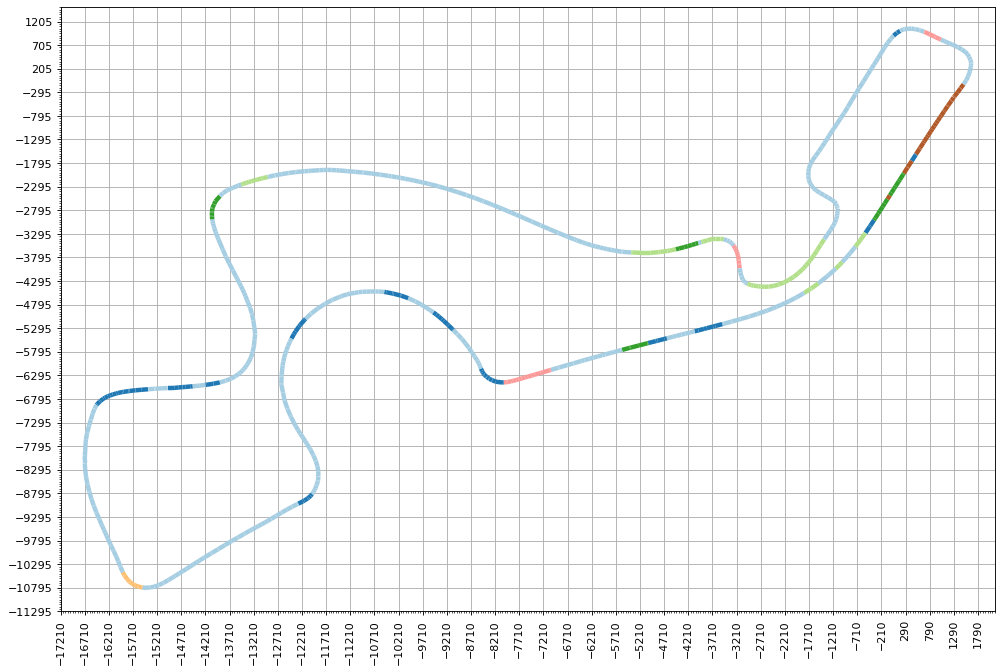

In [10]:
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.pyplot as plt

max_x = overtakes_to_display['X'].max() + 500
min_x = overtakes_to_display['X'].min() - 500
max_y = overtakes_to_display['Y'].max() + 500
min_y = overtakes_to_display['Y'].min() - 500

fig,ax = plt.subplots(figsize=(10 * (max_x + abs(min_x)) / (max_y + abs(min_y)), 10), dpi=80)

overtake = overtakes_to_display['nOvertakes'].to_numpy().astype(float)

cmap = cm.get_cmap('Paired')
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(overtake)
lc_comp.set_linewidth(4)
ax.add_collection(lc_comp)

major_ticks_x = np.arange(min_x, max_x, 10 * x_size_of_sector)
minor_ticks_x = np.arange(min_x, max_x, x_size_of_sector)

major_ticks_y = np.arange(min_y, max_y, 10 * y_size_of_sector)
minor_ticks_y = np.arange(min_y, max_y, y_size_of_sector)

ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
plt.grid()
plt.xticks(rotation=90)
plt.show()

<a id="tracks"> Попробуем получить настоящие данные трасс ( увы, дальнейшее использование невозможно т.к. датасет не содержит все нужные треки, но он достоин упомянания: </a>
<a href="https://github.com/TUMFTM/racetrack-database"> github.com </a>

In [11]:
map_data = pd.read_csv("Monza.csv")
map_data.rename(columns={"# x_m": "x_m"}, inplace=True)

<ipython-input-12-63169f991a4a>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


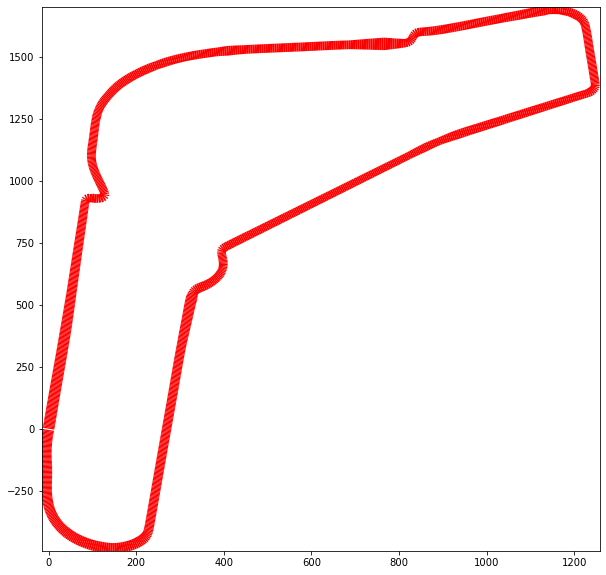

In [12]:
x = map_data['x_m']
y = map_data['y_m']
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, linewidths=map_data['w_tr_left_m'] + map_data['w_tr_right_m'], color='red')
fig, a = plt.subplots(figsize=[10, 10])
a.add_collection(lc)
a.set_xlim(x.min() - 10, x.max() + 10)
a.set_ylim(y.min() - 10, y.max() + 10)
fig.show()

<h3 id='overtakes_all'> Просчет обгонов на конец сектора исходя из данных по началу </h3>
<h4> Алгоритм получения данных описан в файле process_race.py и включает в себя скрипт обработки гонки </h4>
Предполагаемое описание алгоритма:
<ol style="color: red">
<li>Выделить только первые записи для каждого сектора</li>
<li>Посчитать была ли смена позиций в конце сектора</li>
<li>Добавить среднюю скорость на секторе, скорость автомобиля впереди, среднее кол-во обгонов на секторе за круг</li>
</ol>

Что важно отметить:
Мы уберем упомянание команды и гонщика из выборки, вот по каким причинам: из года в год значимость команды меняется, то, что мерседес доминировали в 2019 году не дает никаких гарантий на последующие гонки. Введём альтернативу: позиция команды в кубке конструкторов и позиция гонщика в общем зачете на данный момент

Нами был сформирован достаточно обширный датасет хранящий в себе данный о гонщике и данные о гонщике впереди, мы попытаемся предсказать был ли обгон в конце сектора по началу сектора

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve, accuracy_score

In [14]:
data = pd.read_csv("complete_df_2021_1.csv")
data = data.append(pd.read_csv("complete_df_2021_2.csv"))
data = data.append(pd.read_csv("complete_df_2021_3.csv"))
data = data.append(pd.read_csv("complete_df_2021_4.csv"))
data = data.append(pd.read_csv("complete_df_2021_5.csv"))
data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
X = data.drop(columns=['Overtake', 'Status', 'SessionTime', 'Date', 'Source', 'Time'])
y = data['Overtake']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<ipython-input-14-04886de63b6b>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.read_csv("complete_df_2021_2.csv"))
<ipython-input-14-04886de63b6b>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.read_csv("complete_df_2021_3.csv"))
<ipython-input-14-04886de63b6b>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.read_csv("complete_df_2021_4.csv"))
<ipython-input-14-04886de63b6b>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.read_csv("complete_df_2021_5.csv"))


In [15]:
from sklearn.model_selection import RandomizedSearchCV

def search_best_params(X_df, y_df):
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']

    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)

    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='precision', cv = 5, n_iter=400, verbose=2, random_state=50, n_jobs = -1)
    rf_random.fit(X_df, y_df)
    return rf_random

In [16]:
clf = RandomForestClassifier(n_estimators= 800, min_samples_split= 2, min_samples_leaf = 1, max_features='auto',max_depth=100, bootstrap= True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f1_score(y_pred, y_test), roc_auc_score(y_pred, y_test), precision_score(y_pred, y_test), recall_score(y_pred, y_test), precision_recall_curve(y_pred, y_test))

0.7686832740213523 0.973272710276491 0.6390532544378699 0.9642857142857143 (array([0.03154485, 0.63905325, 1.        ]), array([1.        , 0.96428571, 0.        ]), array([0., 1.]))


Общая идея алгоритма: мы предсказываем вероятность обгона на каждом отдельном участке, если вероятность обгона выросла -> мы даем гонщику очки, если вероятность понизилась - забираем. Если гонщик совершил обгон - добавляем 1 - вероятность обгона, если гонщика обогнали, то из его очков вычитаем 1 - вероятность обгона, назовем этот параметр adv: attack-defence value. Аналогично, в дальнейшем планируется добавить возможность оценивать атаку и оборону отдельно.
В дальнейшем планируется комплексно оценивать и другие действия пилотов.

reference model: <a href="https://statsbomb.com/articles/soccer/introducing-on-ball-value-obv/"> statsbomb obv </a>

In [17]:
y_proba = clf.predict_proba(X)
X['probability_of_overtake'] = y_proba[:, 1]
X['points_gained'] = np.zeros(len(X))

In [18]:
for driver in X['DriverNumber'].unique():
    driver_df = X[X['DriverNumber'] == driver].copy()
    driver_df['points_gained'] = driver_df['probability_of_overtake'].diff()
    X.loc[X['DriverNumber'] == driver, 'points_gained'] = driver_df['points_gained']

X['points_gained'] = X['points_gained'].fillna(0)

На данном этапе мы имеем датафрейм,который содержит подробную информацию о кругах, которые гонщик совершил в квалификации, теперь давайте сформируем данные, которые мы будем анализировать, а именно - результаты квалификации. Мы хотим добавить следующие параметры:
- adv гонщика на данной трассе за все время
- adv гонщика в сезоне
- является ли гонка домашней
- положение гонщика в общем зачете
- положение команды в общем зачете
- погода
- перцентиль гонщика по очкам
- перцентиль команды по очкам
и др.

<h3 id="predictor">Предскажем результат гонки по результату квалификации без использования метрики</h3>

Для начала получим национальности гонщиков и команд. Это может быть важно, так как когда мы говорим о спорте нельзя не учитывать психологический эффект

In [19]:
# данные о круге
def get_circuit(season, race):
    request = requests.get(f'http://ergast.com/api/f1/{season}/{race}/circuits.json').json()['MRData']['CircuitTable']['Circuits'][0]
    return {"country": request['Location']['country'], "circuit_name": request['circuitName']}

In [20]:
# очки гонщика
def get_driver_points(race_results, driver):
    try:
        return race_results.loc[driver['name']]['points']
    except KeyError:
        return 0

# "stantings" гонщиков и команд на опеределенную гонку
def get_standings(season, race,  drivers, constructors):
    constructors_standings = pd.DataFrame({
        'name': constructors.index,
        'points': np.zeros(len(constructors)),
    })
    drivers_standings = pd.DataFrame({
        'name': drivers.index,
        'points': np.zeros(len(drivers)),
    })
    for r in range(1, race):
        while True:
            try:
                race_results = requests.get(f'http://ergast.com/api/f1/{season}/{r}/results.json').json()['MRData']['RaceTable']['Races'][0]['Results']
                break
            except Exception as e:
                logging.error(e)

        race_results = pd.DataFrame.from_dict(race_results)
        if 'FastestLap' in race_results.columns:
            race_results.drop(columns=['FastestLap'], inplace=True)
        race_results['constructor'] = race_results['Constructor'].apply(lambda constructor: constructor['name'])
        race_results['driverCode'] = race_results['Driver'].apply(lambda driver: driver['code'])
        race_results.drop(columns=['Constructor', 'Time', 'status', 'laps', 'positionText', 'Driver', 'grid'], inplace=True)
        race_results['number'] = race_results['number'].astype(str)
        race_results = race_results.set_index(['driverCode'])
        race_results['points'] = race_results['points'].astype(float)
        drivers_standings['points'] = drivers_standings.apply(lambda driver:
                                                                        driver['points'] + get_driver_points(race_results, driver), axis=1)
        constructors_standings['points'] = constructors_standings.apply(lambda constructor:
                                                                        constructor['points'] + race_results[race_results['constructor'] == constructor['name']]['points'].sum(), axis=1)
    return drivers_standings, constructors_standings

In [21]:
def process_api_response(response):
    results = pd.DataFrame.from_dict(response)
    df_drivers = pd.DataFrame(results['Driver'].tolist())
    df_constructor = pd.DataFrame(results['Constructor'].tolist())
    df_constructor.rename(columns={'nationality': 'team_nationality'}, inplace=True)
    results = pd.concat([results, df_drivers, df_constructor], axis=1)
    results.drop(columns=['Driver', 'Constructor', 'positionText', 'Time', 'FastestLap', 'url', 'givenName', 'familyName', 'dateOfBirth', 'permanentNumber'], inplace=True,  errors='ignore')
    return results.set_index(['code'])

In [22]:
def get_session_dataframe(season, race):
    # гонщики
    drivers = requests.get(f'http://ergast.com/api/f1/{season}/{race}/drivers.json').json()['MRData']['DriverTable']['Drivers']
    if len(drivers) == 0:
        return None, "season or race not found"
    drivers = pd.DataFrame.from_dict(drivers)
    drivers.drop(columns=['url', 'driverId', 'permanentNumber'], inplace=True)
    drivers = drivers.set_index(['code'])

    # национальности - страна
    nationalities = pd.read_csv('countries.csv')
    nationalities.drop(columns=['CCA2', 'CCA3'], inplace=True)
    nationalities = nationalities.set_index('Name').T.to_dict('records')[0]

    # конструкторы
    constructors = requests.get(f'http://ergast.com/api/f1/{season}/{race}/constructors.json').json()['MRData']['ConstructorTable']['Constructors']
    constructors = pd.DataFrame.from_dict(constructors)
    constructors.drop(columns=['url', 'constructorId'], inplace=True)
    constructors = constructors.set_index(['name'])

    # standings
    drivers_standings, constructors_standings = get_standings(selected_season, race, drivers, constructors)
    constructors_standings = constructors_standings.set_index(['name'])
    drivers_standings = drivers_standings.set_index(['name'])

    # трасса
    circuit = get_circuit(season, race)
    circuit_country, circuit_name = circuit['country'], circuit['circuit_name']

    quali_data = pd.DataFrame({
        'DriverAbbreviation': [],
        'Team': [],
        'IsAtHomeDriver': [],
        'IsAtHomeTeam': [],
        'ConstructorsStandingPercentile': [],
        'DriversChampionshipPercentile': [],
        'QualiPlace': [],
        'StartingGridPlace': [],
        'ClearWeather': [],
        'LightRainWeather': [],
        'HeavyRainWeather': [],
        'Circuit' : [],
        'Season' : [],
        'Race' : [],
        'Finished': [],
        'RaceResults': []
    })

    try:
        track_country_nationality = nationalities[circuit_country]
    except KeyError:
        logging.error(f"nationality not found: {circuit_country}")
        track_country_nationality = None

    # получаем и обрабатываем результаты квалификации из api
    quali_results = requests.get(f'http://ergast.com/api/f1/{season}/qualifying/{race}/results.json').json()['MRData']['RaceTable']['Races'][0]['Results']
    quali_results = process_api_response(quali_results)

    # получаем результаты гонки из api
    race_results = requests.get(f'http://ergast.com/api/f1/{season}/{race}/results.json').json()['MRData']['RaceTable']['Races'][0]['Results']
    race_results = process_api_response(race_results)

    # получение погоды
    # !!! доступно только для гонок начиная с 2018 года
    try:
        race_session = ff1.get_session(season, race, 'R')
        race_session.load(weather=True)
        weather_clear = not race_session.weather_data['Rainfall'].any()
        weather_h_rain = race_session.weather_data['Rainfall'].all()
        weather_l_rain = race_session.weather_data['Rainfall'].any() and not weather_h_rain

    except Exception as _:
        weather_clear = False
        weather_h_rain = False
        weather_l_rain = False
    for index, driver in drivers.iterrows():
        try:
            driver_row = quali_results.loc[index]
            drivers_place = int(driver_row['position'])
        except KeyError:
            print(index)
            logging.error(f"driver not found, {index}")
            continue

        driver_team = driver_row['name']
        data = [index,
                driver_team,
                track_country_nationality == driver['nationality'],
                constructors.loc[driver_team]['nationality'] == track_country_nationality,
                stats.percentileofscore(constructors_standings['points'], constructors_standings.loc[driver_team]['points']) / 100,
                stats.percentileofscore(drivers_standings['points'], drivers_standings.loc[index]['points']) / 100,
                drivers_place,
                int(race_results.loc[index]['grid']),
                weather_clear,
                weather_l_rain,
                weather_h_rain,
                circuit_name,
                season,
                race,
                race_results.loc[index]['status'],
                int(race_results.loc[index]['position']),
                ]
        quali_data = pd.concat([pd.DataFrame([data], columns=quali_data.columns), quali_data], ignore_index=True)
    return quali_data, None

In [32]:
import time
total_df = pd.DataFrame({
    'DriverAbbreviation': [],
    'Team': [],
    'IsAtHomeDriver': [],
    'IsAtHomeTeam': [],
    'ConstructorsStandingPercentile': [],
    'DriversChampionshipPercentile': [],
    'QualiPlace': [],
    'ClearWeather': [],
    'LightRainWeather': [],
    'HeavyRainWeather': [],
    'Circuit' : [],
    'Season' : [],
    'Race' : [],
    'RaceResults': [],
})

tracks_processed = {}

for year in range(2021, 2017, -1):
    for race in range(1, 25):
        logging.info(f"{year}, {race} - started")
        errors_number = 0
        while True:
            try:
                new_df, error = get_session_dataframe(year, race)
                break
            except Exception as e:
                errors_number += 1
                logging.error(e)
                time.sleep(0.5)
                if errors_number > 10:
                    error = e
                    logging.critical(f"Unable to fix error, race {race} in {year} skipped")
                    break

        if error is not None:
            logging.error(error)
            if error == "season or race not found":
                break
        elif year > 2017:
            session = ff1.get_session(year, race, 'R')
            session.load(laps=True, telemetry=True)
            laps = session.laps
            laps['LapEndTime'] = laps['LapStartTime'] + laps['LapTime']
            overtakes = calculate_overtakes_during_race(laps, year, race)
            if len(new_df['Circuit']) > 0:
                if new_df.iloc[0]['Circuit'] not in tracks_processed:
                    tracks_processed[new_df.iloc[0]['Circuit']] = {}
                    tracks_processed[new_df.iloc[0]['Circuit']]['total_overtakes'] = 0
                    tracks_processed[new_df.iloc[0]['Circuit']]['num_of_races'] = 0
                tracks_processed[new_df.iloc[0]['Circuit']]['total_overtakes'] += len(overtakes)
                tracks_processed[new_df.iloc[0]['Circuit']]['num_of_races'] += 1
        total_df = pd.concat([new_df, total_df], ignore_index=True)

<ipython-input-32-09fdf21882e5>       INFO 	2021, 1 - started
core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.2.4]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '4', '11', '16', '3', '55', '22', '18', '7', '99', '31', '63', '5', '47', '10', '6', '14', '9']
<ipython-input-22-e0b40f7f5118>:103: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (in

KUB


core           INFO 	Loading data for Dutch Grand Prix - Race [v2.2.4]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '10', '16', '14', '55', '11', '31', '4', '3', '18', '5', '99', '88', '6', '63', '47', '22', '9']
<ipython-input-6-44750a5f9966>   CRITICAL 	MORE THAN ONE MISSING STARTING GRID VALUE
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-32-09fdf21882e5>       INFO 	2021, 14 - started
core           INFO 	Loading data for 

KUB


core           INFO 	Loading data for Italian Grand Prix - Race [v2.2.4]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '77', '16', '11', '55', '18', '14', '63', '31', '6', '5', '99', '88', '47', '9', '44', '33', '10', '22']
<ipython-input-6-44750a5f9966>   CRITICAL 	MORE THAN ONE MISSING STARTING GRID VALUE
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>      

HUL


core           INFO 	Loading data for British Grand Prix - Race [v2.2.4]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '16', '3', '4', '31', '10', '23', '18', '5', '77', '63', '55', '99', '6', '8', '7', '26', '20', '27']
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-32-09fdf21882e5>       INFO 	2020, 5 - started
<ipython-input-22-e0b40f7f5118>      ERROR 	nationality not found: UK
core           INFO 	Loading data for 70th Anniversar

HUL


core           INFO 	Loading data for 70th Anniversary Grand Prix - Race [v2.2.4]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '16', '23', '18', '27', '31', '4', '26', '10', '5', '55', '3', '7', '8', '99', '63', '6', '20']
<ipython-input-32-09fdf21882e5>       INFO 	2020, 6 - started
core           INFO 	Loading data for Spanish Grand Prix - Race [v2.2.4]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing

HUL


core           INFO 	Loading data for Eifel Grand Prix - Race [v2.2.4]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '3', '11', '55', '10', '16', '27', '8', '99', '5', '7', '20', '6', '26', '4', '23', '31', '77', '63']
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pi

AIT
FIT


core           INFO 	Loading data for Sakhir Grand Prix - Race [v2.2.4]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['11', '31', '18', '55', '3', '23', '26', '77', '63', '4', '10', '5', '99', '7', '20', '89', '51', '6', '33', '16']
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-6-44750a5f9966>       INFO 	Overtake during 

FIT


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v2.2.4]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Finished loading data for 20 drivers: ['33', '77', '44', '23', '4', '55', '3', '10', '31', '18', '26', '7', '16', '5', '63', '99', '6', '20', '51', '11']
<ipython-input-6-44750a5f9966>       INFO 	Overtake during pit
<ipython-input-32-09fdf21882e5>       INFO 	2020, 18 - started
<ipython-input-32-09fdf21882e5>      ERROR 	season or race not found
<ipython-input-32-09fdf21882e5>       INFO 	2019, 

In [41]:
total_df

,Unnamed: 0,DriverAbbreviation,Team,IsAtHomeDriver,IsAtHomeTeam,ConstructorsStandingPercentile,DriversChampionshipPercentile,QualiPlace,StartingGridPlace,ClearWeather,LightRainWeather,HeavyRainWeather,Circuit,Season,Race,Finished,RaceResults,Average_track_overtakes
0,0,VET,Ferrari,0.0,0.0,0.80,0.500,1.0,3.0,0.0,1.0,0.0,Yas Marina Circuit,2018.0,21.0,Finished,2.0,160.5
1,1,VER,Red Bull,0.0,0.0,0.90,1.000,6.0,6.0,0.0,1.0,0.0,Yas Marina Circuit,2018.0,21.0,Finished,3.0,160.5
2,2,VAN,McLaren,0.0,0.0,0.70,0.200,9.0,18.0,0.0,1.0,0.0,Yas Marina Circuit,2018.0,21.0,+1 Lap,14.0,160.5
3,3,STR,Williams,0.0,0.0,0.60,0.450,14.0,20.0,0.0,1.0,0.0,Yas Marina Circuit,2018.0,21.0,+1 Lap,13.0,160.5
4,4,SIR,Williams,0.0,0.0,0.60,0.200,20.0,19.0,0.0,1.0,0.0,Yas Marina Circuit,2018.0,21.0,+1 Lap,15.0,160.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3219,1607,HAM,Mercedes,0.0,0.0,0.55,0.525,1.0,2.0,1.0,0.0,0.0,Bahrain International Circuit,2021.0,1.0,Finished,1.0,NaN
3220,1608,GIO,Alfa Romeo,0.0,0.0,0.55,0.525,12.0,12.0,1.0,0.0,0.0,Bahrain International Circuit,2021.0,1.0,+1 Lap,12.0,NaN
3221,1609,GAS,AlphaTauri,0.0,0.0,0.55,0.525,17.0,5.0,1.0,0.0,0.0,Bahrain International Circuit,2021.0,1.0,Retired,17.0,NaN
3222,1610,BOT,Mercedes,0.0,0.0,0.55,0.525,3.0,3.0,1.0,0.0,0.0,Bahrain International Circuit,2021.0,1.0,Finished,3.0,NaN


In [38]:
tracks_processed

{'Bahrain International Circuit': {'total_overtakes': 1014, 'num_of_races': 5},
 'Autodromo Enzo e Dino Ferrari': {'total_overtakes': 361, 'num_of_races': 2},
 'Autódromo Internacional do Algarve': {'total_overtakes': 377,
  'num_of_races': 2},
 'Circuit de Barcelona-Catalunya': {'total_overtakes': 630, 'num_of_races': 4},
 'Circuit de Monaco': {'total_overtakes': 207, 'num_of_races': 3},
 'Baku City Circuit': {'total_overtakes': 608, 'num_of_races': 3},
 'Circuit Paul Ricard': {'total_overtakes': 258, 'num_of_races': 3},
 'Red Bull Ring': {'total_overtakes': 797, 'num_of_races': 6},
 'Silverstone Circuit': {'total_overtakes': 940, 'num_of_races': 5},
 'Hungaroring': {'total_overtakes': 597, 'num_of_races': 4},
 'Circuit de Spa-Francorchamps': {'total_overtakes': 354, 'num_of_races': 4},
 'Circuit Park Zandvoort': {'total_overtakes': 121, 'num_of_races': 1},
 'Autodromo Nazionale di Monza': {'total_overtakes': 664, 'num_of_races': 4},
 'Sochi Autodrom': {'total_overtakes': 669, 'num_of

In [43]:
# установка среднего кол-ва обгонов на трассах
def set_overtakes(row, tracks):
    if row['Circuit'] in tracks:
        track = tracks[row['Circuit']]
        if track['total_overtakes'] == 0:
            return np.NAN
        return track['total_overtakes'] / track['num_of_races']
    else:
        return np.NAN

In [44]:
total_df['Average_track_overtakes'] = total_df.apply(lambda row: set_overtakes(row, tracks_processed), axis=1)

In [45]:
total_df['Average_track_overtakes'] = total_df['Average_track_overtakes'].fillna(total_df['Average_track_overtakes'].min())

In [46]:
total_df.to_csv("total_df_saved.csv")

In [74]:
total_df = pd.read_csv("total_df_saved.csv")

In [75]:
total_df

,Unnamed: 0,DriverAbbreviation,Team,IsAtHomeDriver,IsAtHomeTeam,ConstructorsStandingPercentile,DriversChampionshipPercentile,QualiPlace,StartingGridPlace,ClearWeather,LightRainWeather,HeavyRainWeather,Circuit,Season,Race,Finished,RaceResults,Average_track_overtakes
0,0,VET,Ferrari,0.0,0.0,0.80,0.500,1.0,3.0,0.0,1.0,0.0,Yas Marina Circuit,2018.0,21.0,Finished,2.0,160.5
1,1,VER,Red Bull,0.0,0.0,0.90,1.000,6.0,6.0,0.0,1.0,0.0,Yas Marina Circuit,2018.0,21.0,Finished,3.0,160.5
2,2,VAN,McLaren,0.0,0.0,0.70,0.200,9.0,18.0,0.0,1.0,0.0,Yas Marina Circuit,2018.0,21.0,+1 Lap,14.0,160.5
3,3,STR,Williams,0.0,0.0,0.60,0.450,14.0,20.0,0.0,1.0,0.0,Yas Marina Circuit,2018.0,21.0,+1 Lap,13.0,160.5
4,4,SIR,Williams,0.0,0.0,0.60,0.200,20.0,19.0,0.0,1.0,0.0,Yas Marina Circuit,2018.0,21.0,+1 Lap,15.0,160.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607,1607,HAM,Mercedes,0.0,0.0,0.55,0.525,1.0,2.0,1.0,0.0,0.0,Bahrain International Circuit,2021.0,1.0,Finished,1.0,202.8
1608,1608,GIO,Alfa Romeo,0.0,0.0,0.55,0.525,12.0,12.0,1.0,0.0,0.0,Bahrain International Circuit,2021.0,1.0,+1 Lap,12.0,202.8
1609,1609,GAS,AlphaTauri,0.0,0.0,0.55,0.525,17.0,5.0,1.0,0.0,0.0,Bahrain International Circuit,2021.0,1.0,Retired,17.0,202.8
1610,1610,BOT,Mercedes,0.0,0.0,0.55,0.525,3.0,3.0,1.0,0.0,0.0,Bahrain International Circuit,2021.0,1.0,Finished,3.0,202.8


In [47]:
from sklearn import preprocessing

scaled_features = total_df.copy()

col_names = ['QualiPlace', 'StartingGridPlace', 'Average_track_overtakes']
features = scaled_features[col_names]
# Use scaler of choice; here Standard scaler is used
scaler = preprocessing.MinMaxScaler()
scaler.fit(X=features.values)
features = scaler.transform(features.values)

scaled_features[col_names] = features

In [48]:
total_df = scaled_features.copy()

In [49]:
total_df_dummies = total_df.drop(columns=['Team', 'Unnamed: 0', 'Finished'])
finished_column = total_df['Finished']
total_df_dummies = total_df_dummies.join(pd.get_dummies(total_df_dummies.select_dtypes(include=['object'])))
total_df_dummies.drop(columns=total_df_dummies.select_dtypes(include=['object']).columns, inplace=True)
total_df_dummies['Finished'] = finished_column
train = total_df_dummies[total_df_dummies['Season'] < 2019]
test = total_df_dummies[total_df_dummies['Season'] > 2018]

X_train = train.drop(columns=['RaceResults'])
X_test = test.drop(columns=['RaceResults'])
y_train = train['RaceResults'] == 1
y_test = (test['RaceResults'] == 1).astype(int)

In [50]:
X_train.shape

(840, 72)

In [51]:
# победителем определенной гонки считаем гонщика, у которого наибольшая вероятность победы
def transform_predictions(X_test, y_pred):
    X_preds = X_test.copy()
    X_preds['win_proba'] = y_pred[:, 1]
    for name, group in X_preds.groupby(['Season', 'Race']):
        X_preds.loc[(X_preds['Season'] == name[0]) & (X_preds['Race'] == name[1]), 'winner'] = X_preds[(X_preds['Season'] == name[0]) & (X_preds['Race'] == name[1])]['win_proba'] == max(group['win_proba'])
    y_pred = X_preds['winner'].astype(int)
    return y_pred

In [52]:
clf_searched = search_best_params(X_train.drop(columns=['Finished']), y_train)
clf = clf_searched.best_estimator_
y_pred = clf.predict_proba(X_test.drop(columns=['Finished']))
y_pred = transform_predictions(X_test.drop(columns=['Finished']), y_pred)
f1_score(y_pred, y_test), roc_auc_score(y_pred, y_test), precision_score(y_pred, y_test), recall_score(y_pred, y_test)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


(0.5, 0.736749116607774, 0.5, 0.5)

In [53]:
clf_searched.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [83]:
clf = RandomForestClassifier(n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features='auto', max_depth=110, bootstrap=False)
clf.fit(X_train.drop(columns=['Finished']), y_train)
y_pred = clf.predict_proba(X_test.drop(columns=['Finished']))
y_pred = transform_predictions(X_test, y_pred)
f1_score(y_pred, y_test), roc_auc_score(y_pred, y_test), precision_score(y_pred, y_test), recall_score(y_pred, y_test), accuracy_score(y_pred, y_test)

(0.55, 0.7630742049469965, 0.55, 0.55, 0.9546979865771812)

In [54]:
from sklearn.linear_model import LogisticRegression
# без параметра средних обгонов на трассе точность была в 1.5 раза ниже
lr = LogisticRegression(max_iter=5000, C=0.001)
lr.fit(X_train.drop(columns=['Finished']), y_train)
y_pred = lr.predict_proba(X_test.drop(columns=['Finished']))
y_pred = transform_predictions(X_test, y_pred)
f1_score(y_pred, y_test), roc_auc_score(y_pred, y_test), precision_score(y_pred, y_test), recall_score(y_pred, y_test)

(0.5, 0.736749116607774, 0.5, 0.5)

In [55]:
from sklearn.svm import SVC
def search_best_params_svc(X_df, y_df):
    kernels = ['rbf', 'poly']
    gammas = [0.1, 1, 10, 100]
    cs = [0.1, 1, 10, 100, 1000]

    random_grid = {
        'kernel': kernels,
        'gamma': gammas,
        'C': cs
    }

    rf = SVC()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='precision', cv=3, n_iter=30, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_df, y_df)
    return rf_random

In [56]:
clf_searched = search_best_params_svc(X_train.drop(columns=['Finished']), y_train)
clf = clf_searched.best_estimator_
y_pred = clf.predict_proba(X_test.drop(columns=['Finished']))
y_pred = transform_predictions(X_test, y_pred)
f1_score(y_pred, y_test), roc_auc_score(y_pred, y_test), precision_score(y_pred, y_test), recall_score(y_pred, y_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


KeyboardInterrupt: 

In [59]:
%%time
from sklearn.svm import SVC

clf = SVC(gamma="auto", kernel='poly', probability=True, verbose=100)
clf.fit(X_train.drop(columns=['Finished']), y_train)
y_pred = clf.predict_proba(X_test.drop(columns=['Finished']))
y_pred = transform_predictions(X_test, y_pred)
f1_score(y_pred, y_test), roc_auc_score(y_pred, y_test), precision_score(y_pred, y_test), recall_score(y_pred, y_test)

[LibSVM]CPU times: user 110 ms, sys: 4.34 ms, total: 114 ms
Wall time: 116 ms


(0.48333333333333334,
 0.7279740871613664,
 0.48333333333333334,
 0.48333333333333334)

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(
    loss='exponential',
    n_estimators=1400,
    learning_rate=2,
    max_depth=10,
    criterion='mse',
    max_features='sqrt',
    random_state=42).fit(X_train.drop(columns=['Finished']), y_train)
y_pred = gbc.predict_proba(X_test.drop(columns=['Finished']))
y_pred = transform_predictions(X_test, y_pred)
f1_score(y_pred, y_test), roc_auc_score(y_pred, y_test), precision_score(y_pred, y_test), recall_score(y_pred, y_test)

(0.45, 0.7104240282685512, 0.45, 0.45)

Как мы можем заметить, качество оставляет желать лучшего у нашей модели, однако, во время гонки может произойти множество неожиданных моментов, исключим те гонки, где гонщики вообще не финишировали по техническим причинам.

In [62]:
test_predictions = X_test.copy()
test_predictions['result'] = y_test
test_predictions['predicted'] = y_pred
test_predictions[(test_predictions['result'] == 0) & (test_predictions['predicted'] == 1)]['Finished'].value_counts()

Finished      58
Collision      4
Suspension     2
Driveshaft     2
Name: Finished, dtype: int64